In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import random
import shutil
tf.random.set_seed(1)
random.seed(1)

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
height = 512

In [4]:
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_6/Sigmoid:0', description="created by layer 'conv2d_transpose_6'")


In [5]:
val_transforms = albu.Compose([
    albu.Resize(height, height),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
valdataset = DatasetCreator(modelcreator.getpreprocess(),val_transforms)

In [7]:
valdata = valdataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

8

In [8]:
trainaugmentation = albu.Compose([
    albu.Resize(height, height),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Transpose(p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    albu.GridDistortion(p=0.5),
    albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.RandomGamma(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
    albu.GaussNoise(),
    albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])#todo change later

In [9]:
traindataset = DatasetCreator(modelcreator.getpreprocess(),trainaugmentation)

In [10]:
traindata = traindataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

20

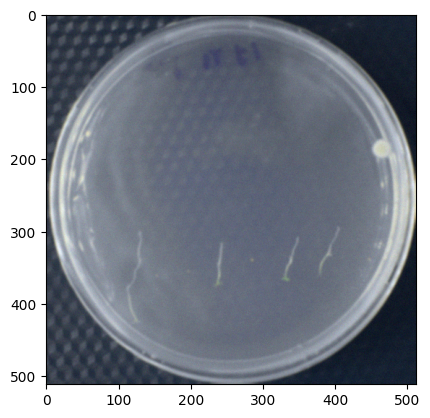

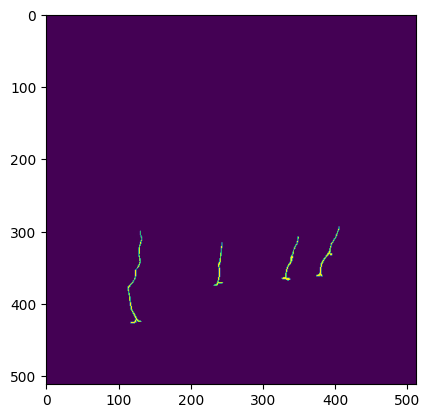

In [11]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

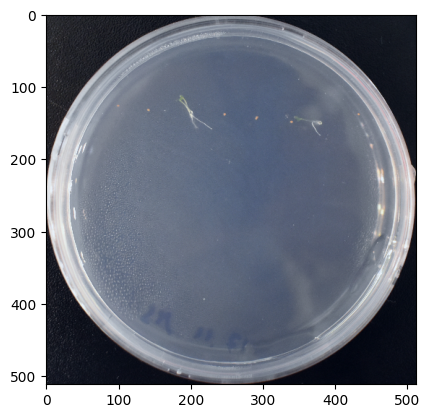

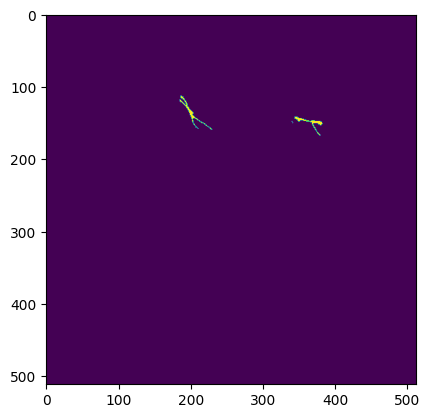

In [12]:
for image,mask in valdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [13]:
#tf.keras.utils.plot_model(model)

In [14]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 15 and epoch % 15 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=30,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [15]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/1000


20/20 [==============================] - ETA: 0s - loss: 1.4970 - iou_score: 0.0099
Epoch 1: val_loss improved from inf to 1.36215, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 39s 2s/step - loss: 1.4970 - iou_score: 0.0099 - val_loss: 1.3621 - val_iou_score: 0.0080 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/1000


KeyboardInterrupt: 

In [ ]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

In [ ]:
results = model.evaluate(testdata)
results

9/9 [==============================] - 2s 102ms/step - loss: 0.4432 - iou_score: 0.5895


[0.4431629776954651, 0.5894734263420105]

In [ ]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 105ms/step


In [ ]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

i = 0

if os.path.isdir('testall/'):
    shutil.rmtree('testall/')
os.makedirs('testall/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('testall/'+str(i)+'.png', vis)